In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from skrmt.ensemble.spectral_law import MarchenkoPasturDistribution

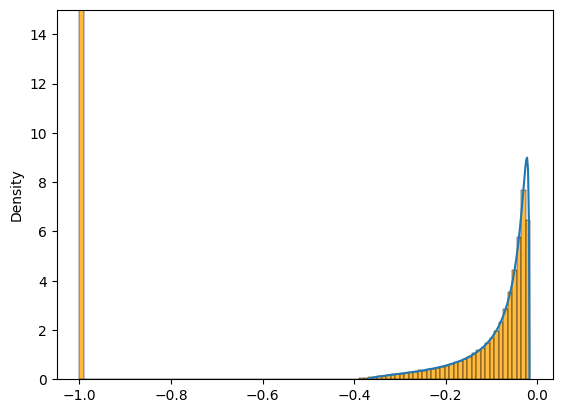

In [6]:
sigma = 1
dim_latent = 50
dim_ambiant = 100

t = 0.1

n = 1000

ev = np.array([])
for _ in range(n):
    F = (sigma/np.sqrt(dim_latent)) * np.random.randn(dim_ambiant, dim_latent)
    J_t = (
        (1/t) * F @ np.linalg.inv(np.eye(dim_latent) + (1/t) * F.T @ F ) @ F.T
        - np.eye(dim_ambiant)
    )
    ev = np.concatenate((ev, np.linalg.eigvals(J_t).real))


def rho(r, t, dim_ambiant, dim_latent):
    alpha_m = dim_latent / dim_ambiant

    lambda_plus = (1 + 1/np.sqrt(alpha_m))**2
    lambda_minus = (1 - 1/np.sqrt(alpha_m))**2
    
    r_plus = -t / (lambda_plus + t)
    r_minus = -t / (lambda_minus + t) 
    
    r_valid = (r > r_minus) & (r < r_plus)
    r = r[r_valid]
    r = np.concatenate((np.array([r_minus]), r, np.array([r_plus])))
    
    density = - (alpha_m / (2 * np.pi)) * (1 / (r * (1 + r))) * \
        np.sqrt((lambda_plus - (-t - (t / r))) * ((-t - (t / r)) - lambda_minus))
    
    return density, r

x = np.linspace(-2, 0, 1000)
y, x_valid = rho(x, t=t, dim_ambiant=dim_ambiant, dim_latent=dim_latent)
plt.plot(x_valid, y)
sns.histplot(ev, stat="density", bins=100, color='orange')
# ev[ev < -0.999] = 0
# sns.kdeplot(ev, bw_adjust=1, color='red')
# plt.hist(ev, density=True, bins=50, color='orange')
# plt.xlim((-1.25, 0.25))
plt.ylim((0, 15))
plt.show()

[WARNING - spectral_law]: Setting ratio >= 1.0 may cause numerical instability. Provided ratio = 2.0.


t = 10.0...
t = 1...
t = 0.01...


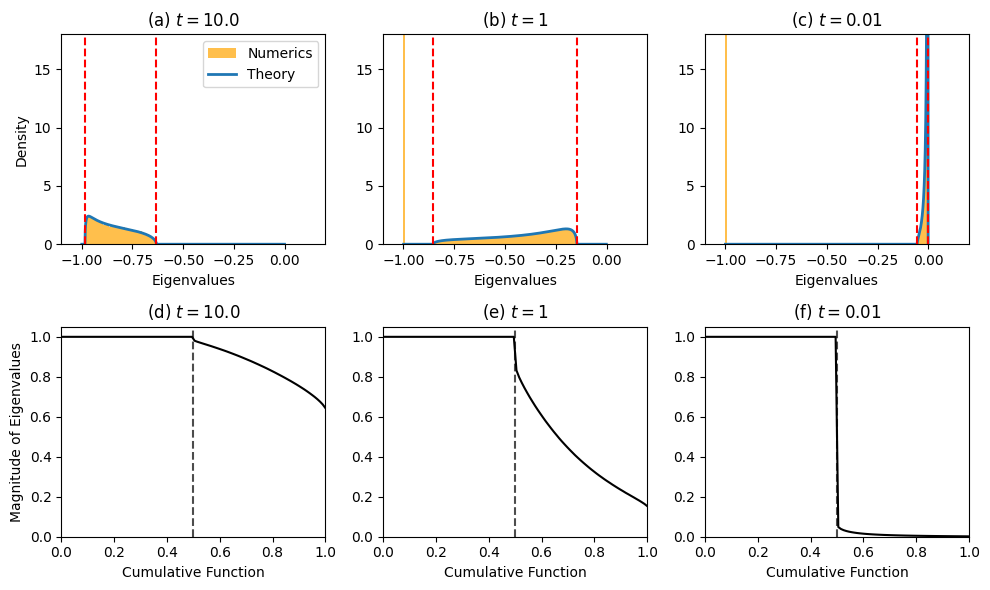

In [13]:
sigma = 1.0
dim_latent = 50  
dim_ambiant = 100 
alpha = dim_latent / dim_ambiant 
n = 1000         

T = [10.0, 1, 0.01] 

MP = MarchenkoPasturDistribution(ratio=dim_ambiant / dim_latent, sigma=sigma)

def panel_label(k):
    return chr(ord('a') + k)


def r_edges(t, alpha):
    s = np.sqrt(alpha)**(-1)
    r_plus  = -t / ((1 - s)**2 + t)  
    r_minus = -t / ((1 + s)**2 + t) 
    return r_minus, r_plus


fig, axes = plt.subplots(2, len(T), figsize=(10, 6))

for i, t in enumerate(T):
    print(f"t = {t}...")

    ev = []
    all_eigs = []

    for _ in range(n):
        F = (sigma / np.sqrt(dim_latent)) * np.random.randn(dim_ambiant, dim_latent)
        FtF = F.T @ F
        J_t = (1/t) * F @ np.linalg.solve(np.eye(dim_latent) + (1/t) * FtF, F.T) - np.eye(dim_ambiant)
        eigs = np.linalg.eigvalsh(J_t)
        ev.append(eigs)
        all_eigs.append(eigs)

    all_eigs = np.array(all_eigs)
    ev = all_eigs.flatten()

    r_grid = np.linspace(-0.999, -1e-3, 4000)

    gamma = -t - (t / r_grid)
    rho_r = (t / (r_grid**2)) * MP.pdf(gamma)

    r_min, r_max = r_edges(t, alpha)


    ax_top = axes[0, i]
    ax_top.hist(ev, bins=150, density=True, color='orange', alpha=0.7, label='Numerics')
    ax_top.plot(r_grid, rho_r, lw=2, label='Theory') 
    ax_top.axvline(r_min, ls='--', lw=1.5, color='r')
    ax_top.axvline(r_max, ls='--', lw=1.5, color='r')

    ax_top.set_title(f"({panel_label(i)}) $t = {t}$")
    ax_top.set_xlim(-1.1, 0.2)
    ax_top.set_ylim(0, 18)
    ax_top.set_xlabel("Eigenvalues")
    if i == 0:
        ax_top.set_ylabel("Density")
        ax_top.legend()



    ax_bot = axes[1, i]
    sorted_per_run = np.sort(np.abs(all_eigs), axis=1)[:, ::-1]
    mean_sorted_mag = np.mean(sorted_per_run, axis=0)
    mean_sorted_mag_normalized = mean_sorted_mag / np.max(mean_sorted_mag)
    cumulative_x = np.linspace(0, 1, dim_ambiant)

    ax_bot.plot(cumulative_x, mean_sorted_mag_normalized, lw=1.5, color='black')
    ax_bot.axvline(x=alpha, ls='--', alpha=0.7, color='k')  

    ax_bot.set_xlim(0, 1.0)
    ax_bot.set_ylim(0, 1.05)
    ax_bot.set_xlabel("Cumulative Function")
    ax_bot.set_title(f"({panel_label(len(T) + i)}) $t = {t}$")
    if i == 0:
        ax_bot.set_ylabel("Magnitude of Eigenvalues")

plt.tight_layout()
plt.show()
